In [1]:
from Gaussian import Gaussian_dist,constant32
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import timeit

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.animation as animation
tfd = tfp.distributions
tfdtype = tf.float32

In [25]:
cov=[[0.5,  0.], [0.,  0.5]]
Gauss_dist = Gaussian_dist(mu = [1.,0.],cov = cov)

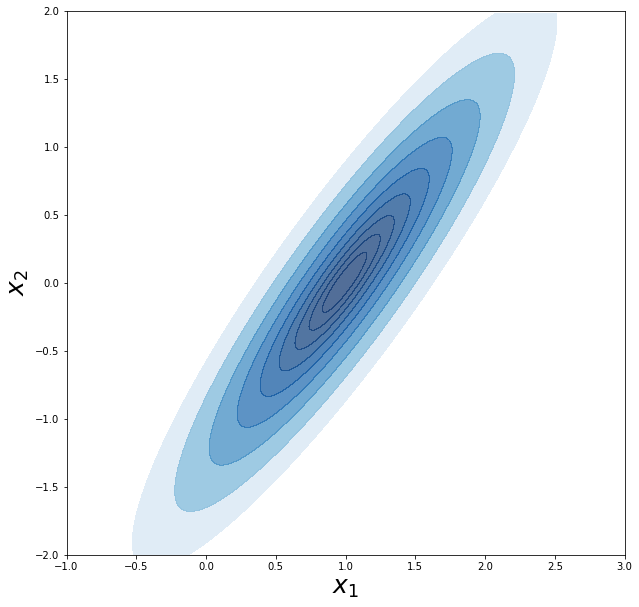

In [26]:
fig,ax = Gauss_dist.draw_post()
# fig.savefig('probe_levels.png', dpi=300)

In [4]:
MAP = tf.convert_to_tensor([0.,-0.],dtype=tfdtype)
with tf.GradientTape(watch_accessed_variables=False) as t:
    t.watch(MAP)
    log_prob = Gauss_dist.joint_log_post(MAP)
loss = t.gradient(log_prob,MAP)
loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.31245613,  0.21871929], dtype=float32)>

[31.687542 -20.7812786]
[31.687542 -20.7812786]
tf.Tensor(
[[-32.        21.      ]
 [ 21.       -16.699999]], shape=(2, 2), dtype=float32)


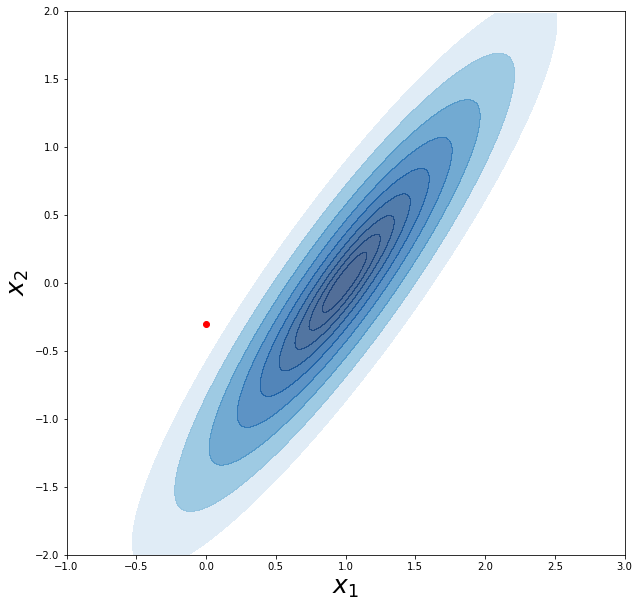

In [28]:
eva_point = [-0.,-0.3]
fig,ax = Gauss_dist.draw_post()
ax.scatter(eva_point[0],eva_point[1],c ='red')
MAP = tf.convert_to_tensor([0.,-0.],dtype=tfdtype)

Hess = tf.TensorArray(tfdtype, size=int(2))
i = 0
for i in range(2):
    tangents = np.zeros(MAP.shape)
    tangents[i]=1
    tangents = tf.convert_to_tensor(tangents,dtype=tfdtype)
    # tangents = [tf.convert_to_tensor(np.array([1.,0.]),dtype=tf.float64)]
    with tf.autodiff.ForwardAccumulator(MAP, tangents) as acc:
        with tf.GradientTape(watch_accessed_variables=False) as t:
            t.watch(MAP)
            log_prob = Gauss_dist.joint_log_post(MAP)
        loss = t.gradient(log_prob,MAP)
        tf.print(loss)
    hess = acc.jvp(loss)
    Hess = Hess.write(i, hess)

Hess = Hess.stack()
print(Hess)


In [6]:
def negative_log_posterior(mu):
    return tf.negative(Gauss_dist.joint_log_post(mu))

In [7]:
mu_init = constant32(eva_point)
Gauss_dist.joint_log_post(mu_init)
# fig.savefig('init.png',dpi=300)
print(mu_init)

tf.Tensor([-0.7 -0.9], shape=(2,), dtype=float32)


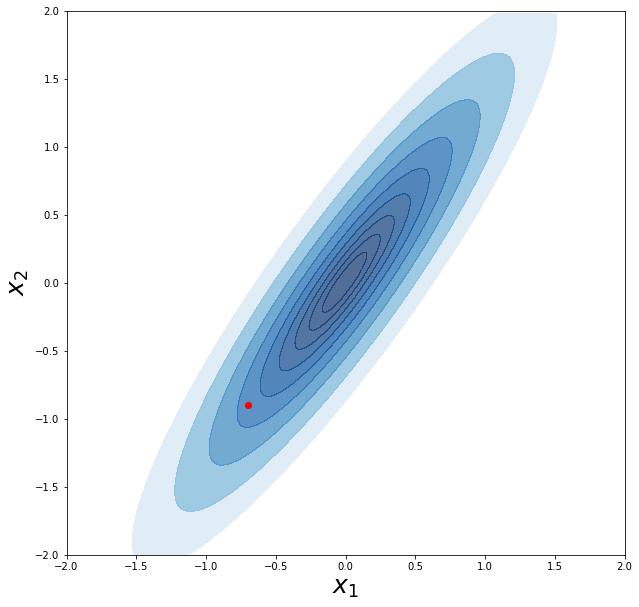

In [8]:
fig

In [9]:
# Function for printing
def loss(mu):
    lost =  negative_log_posterior(mu)
    return lost

# Function for tensorflow optimizer
def loss_minimize():
    lost =  negative_log_posterior(mu)
    return lost

In [10]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.03, beta_1=0.9, beta_2=0.999, epsilon=1e-08
)
cost_A = []
mu_list = [mu_init]
mu = tf.Variable(mu_init)
start = timeit.default_timer()

for step in range(300):

    Adam.minimize(loss_minimize, var_list=[mu])
    cost_A.append(loss(mu).numpy())

    mu_list.append(mu.numpy())
end = timeit.default_timer()

In [11]:
mu_list[-1]

array([-0.00669084,  0.00468336], dtype=float32)

In [12]:
Mu_array = np.array(mu_list)

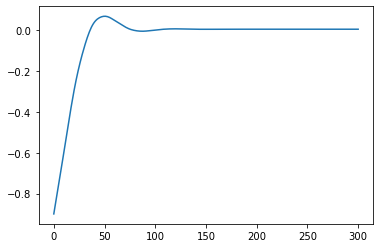

In [13]:
plt.plot(Mu_array[:,1])

In [14]:
Mu_array[0,1]

-0.9

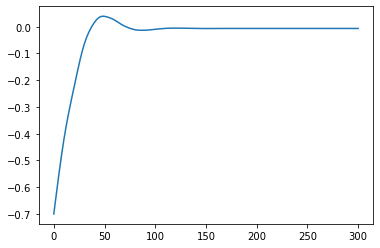

In [15]:
plt.plot(Mu_array[:,0])

In [16]:
ax.plot(Mu_array[:,0],Mu_array[:,1],c = 'darkorange')
ax.scatter(Mu_array[-1,0],Mu_array[-1,1],c='navajowhite')
ax.scatter(Mu_array[0,0],Mu_array[0,1],c='r')
# fig.savefig('Adam.png',dpi=300)

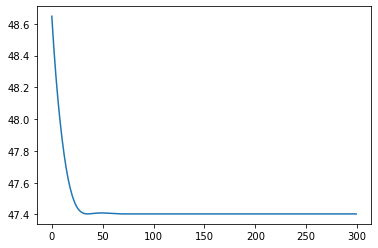

In [17]:
plt.plot(cost_A)

In [18]:
MAP = mu_list[-1]

In [19]:
Gauss_dist.joint_log_post(MAP)

<tf.Tensor: shape=(), dtype=float32, numpy=-47.403347>

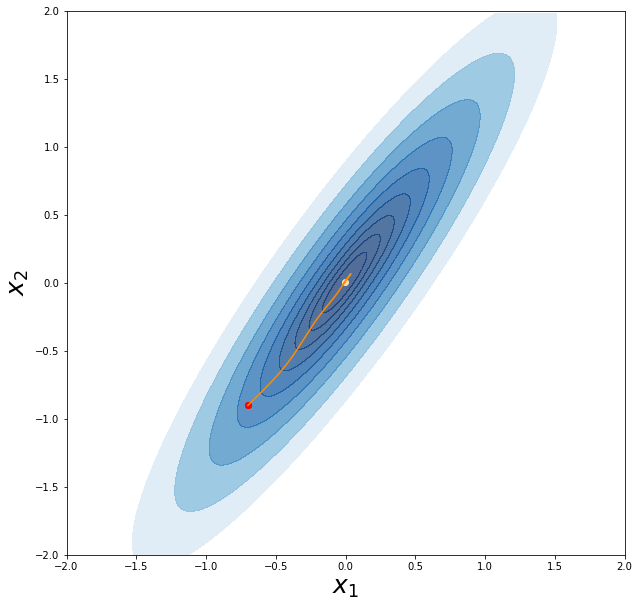

In [20]:
fig

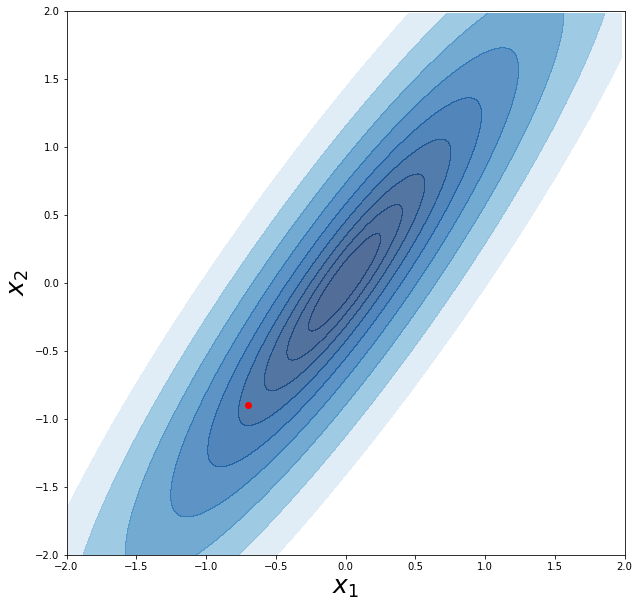

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = Mu_array[:,0]
y = Mu_array[:,1]

fig,ax = Gauss_dist.draw_post()
line, = ax.plot(x, y, color='k')

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    #line.axes.axis([0, 10, 0, 1])
    if num == (x.shape[0]-1):
         ax.scatter(Mu_array[-1,0],Mu_array[-1,1],c='k')
    return line,

ax.scatter(Mu_array[0,0],Mu_array[0,1],c='r')
ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True, repeat=False)

# ani.save('test.gif', dpi = 500,bitrate=500 ,writer='ImageMagick')
plt.show()


In [58]:
MAP = tf.convert_to_tensor(MAP,tfdtype)

In [59]:
Hess = tf.TensorArray(tfdtype, size=int(2))
i = 0
for i in range(2):
    tangents = np.zeros(MAP.shape)
    tangents[i]=1
    tangents = tf.convert_to_tensor(tangents,dtype=tfdtype)
    # tangents = [tf.convert_to_tensor(np.array([1.,0.]),dtype=tf.float64)]
    with tf.autodiff.ForwardAccumulator(MAP, tangents) as acc:
        with tf.GradientTape(watch_accessed_variables=False) as t:
            t.watch(MAP)
            log_prob = -Gauss_dist.joint_log_post(MAP)
        loss = t.gradient(log_prob,MAP)
        tf.print(loss)
    hess = acc.jvp(loss)
    Hess = Hess.write(i, hess)

Hess = Hess.stack()
print(Hess)

[3.12924385e-07 -6.93835318e-07]
[3.12924385e-07 -6.93835318e-07]
tf.Tensor(
[[ 32.       -21.      ]
 [-21.        16.699999]], shape=(2, 2), dtype=float32)


In [60]:
Hess = tf.squeeze(Hess)

In [61]:
def Laplace_appro(Hessian,C_prior):
    cov_post = tf.linalg.inv(
        (tf.add(Hessian, tf.linalg.inv(C_prior))))
    return cov_post

In [62]:
cov_post = Laplace_appro(Hess,constant32([[1.,  0.], [0.,  1.]]))

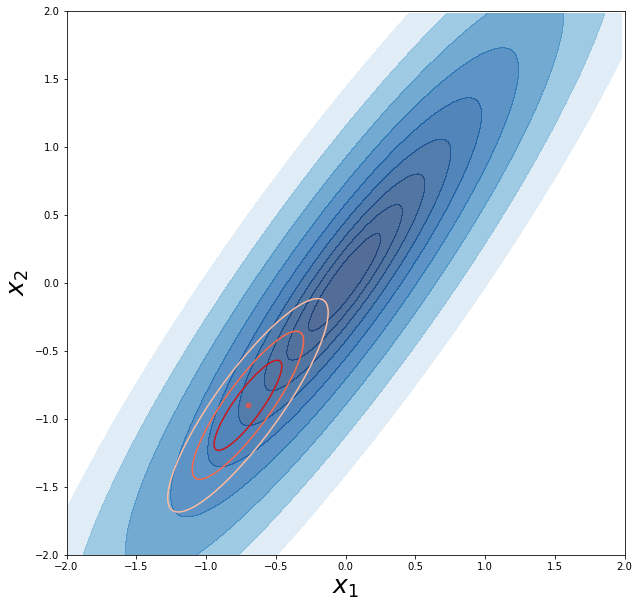

In [73]:
from scipy.stats import multivariate_normal
fig,ax = Gauss_dist.draw_post()
x, y = np.mgrid[(eva_point[0]-1):(eva_point[0]+1):.01, eva_point[1]-1:eva_point[1]+1:.01]
pos1 = np.dstack((x, y))
ax.plot(eva_point[0],eva_point[1], '.',markersize=10, c='indianred')


rv1= multivariate_normal(mean=eva_point,cov=cov_post)
ax.contour(x, y, rv1.pdf(pos1),cmap ='Reds',levels = 3)


## Gaussian proposal

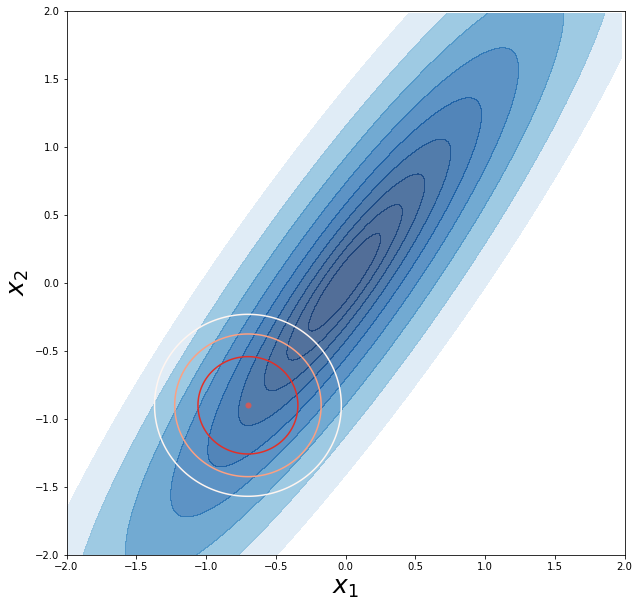

In [74]:
from scipy.stats import multivariate_normal
fig,ax = Gauss_dist.draw_post()
x, y = np.mgrid[(eva_point[0]-0.75):(eva_point[0]+0.75):.01, eva_point[1]-0.75:eva_point[1]+0.75:.01]
pos2 = np.dstack((x, y))
ax.plot(eva_point[0],eva_point[1], '.',markersize=10, c='indianred')

rv2 = multivariate_normal(mean=eva_point,cov=cov)
Max = np.max(rv2.pdf(pos2))
Min = np.min(rv2.pdf(pos2))+0.1
levels = np.linspace(Min,Max,4)
ax.contour(x, y, rv2.pdf(pos2),cmap ='Reds',levels = levels)


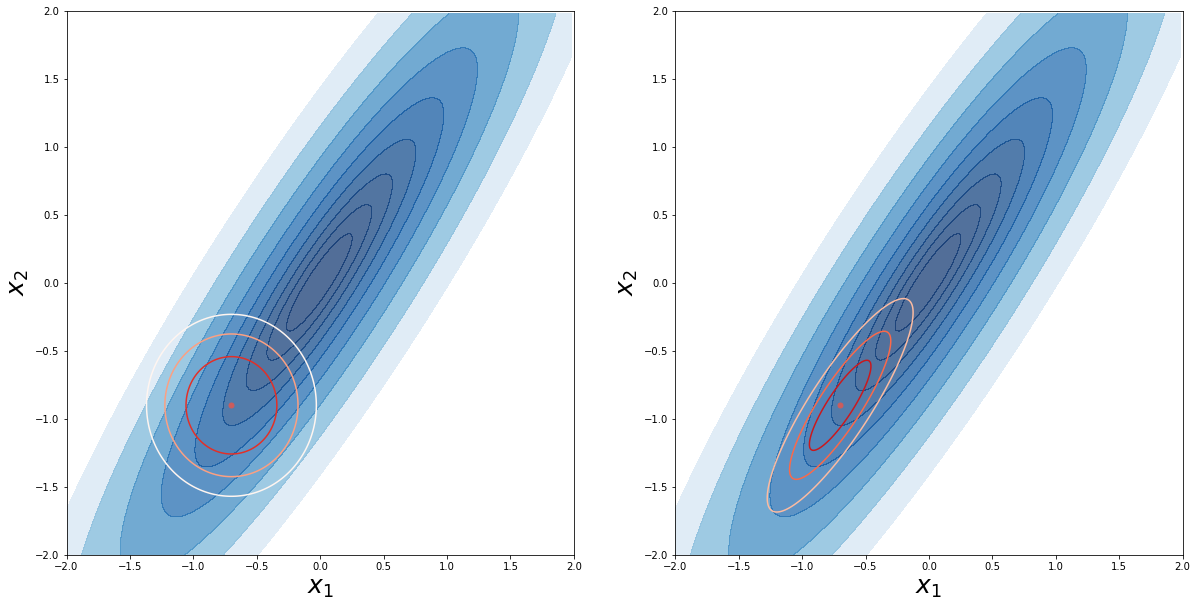

In [76]:
fig, axes = plt.subplots(1,2,figsize= (20,10))
Gauss_dist.draw_post(ax=axes[0])
Gauss_dist.draw_post(ax=axes[1])

x, y = np.mgrid[(eva_point[0]-0.75):(eva_point[0]+0.75):.01, eva_point[1]-0.75:eva_point[1]+0.75:.01]
pos2 = np.dstack((x, y))
axes[0].plot(eva_point[0],eva_point[1], '.',markersize=10, c='indianred')

rv2 = multivariate_normal(mean=eva_point,cov=cov)
Max = np.max(rv2.pdf(pos2))
Min = np.min(rv2.pdf(pos2))+0.1
levels = np.linspace(Min,Max,4)
axes[0].contour(x, y, rv2.pdf(pos2),cmap ='Reds',levels = levels)

x, y = np.mgrid[(eva_point[0]-1):(eva_point[0]+1):.01, eva_point[1]-1:eva_point[1]+1:.01]
pos1 = np.dstack((x, y))
axes[1].plot(eva_point[0],eva_point[1], '.',markersize=10, c='indianred')


rv1= multivariate_normal(mean=eva_point,cov=cov_post)
axes[1].contour(x, y, rv1.pdf(pos1),cmap ='Reds',levels = 3)

# plt.savefig('Liang/Fig/proposal.png',dpi = 400)

## gpCN MCMC

In [77]:
import sys
sys.path.append('/Users/zhouji/Google Drive/RWTH/')
from gpCN import gpCN_MCMC

In [92]:
Cov_prior = tf.cast(Gauss_dist.cov,tf.float32)
MAP = tf.convert_to_tensor(MAP,tfdtype)
Hess = tf.cast(Hess,tf.float32)
beta = tf.constant(0.8,tf.float32)

In [95]:
number_sample = 1000
gpCN = gpCN_MCMC(Hess, 2, negative_log_posterior, MAP, Cov_prior, number_sample=number_sample, number_burnin=0, mu_init=MAP, beta=beta)

Acceptance rate = 83.70%


Text(0.5, 0, 'iterations')

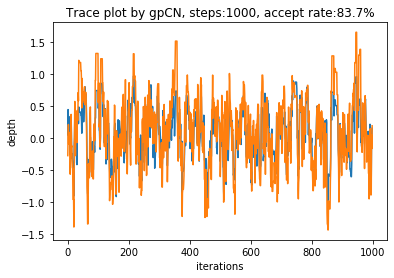

In [96]:
accepted_samples_gpCN, rejected_samples_gpCN, samples_gpCN = gpCN.run_chain_hessian()
accepted_samples_gpCN = np.array(accepted_samples_gpCN)
samples_gpCN = np.array(samples_gpCN)
plt.figure()
plt.plot(samples_gpCN[:,0], label='point 1')
plt.plot(samples_gpCN[:,1], label='point 2')
print('Acceptance rate = %0.2f%%' % (100 * accepted_samples_gpCN.shape[0] / number_sample))
plt.title('Trace plot by gpCN, steps:{}, accept rate:{}%'.format(number_sample,100 * accepted_samples_gpCN.shape[0] / number_sample))
plt.ylabel('depth')
plt.xlabel('iterations')

## RMH MCMC

In [105]:
number_sample=1000
number_burnin = 0

num_results = number_sample
burnin = number_burnin

initial_chain_state = [MAP]

unnormalized_posterior_log_prob = lambda *args: Gauss_dist.joint_log_post(*args)


def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
        for sp in state_parts:
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=seed_stream()))
        return next_state_parts
    return _fn

dtype = np.float32
start = timeit.default_timer()
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.2, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
end = timeit.default_timer()
print('Random walk time in seconds: %.3f' % (end - start))

/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Random walk time in seconds: 6.572


Text(0.5, 1.0, 'Posterior by RMH, steps:1000, accept rate:59.0%')

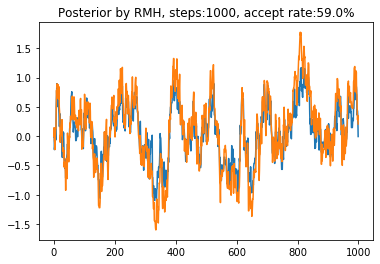

In [106]:
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_RMH = samples[accept_index]
accepted_samples_RMH = np.squeeze(accepted_samples_RMH)

samples_RMH = np.squeeze(samples)
plt.figure()
plt.plot(samples_RMH[:, 0], label='point 1')
plt.plot(samples_RMH[:, 1],label = 'point 2')
plt.title('Posterior by RMH, steps:{}, accept rate:{}%'.format(number_sample,100*accepted_samples_RMH.shape[0]/number_sample))